In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.metrics import mean_squared_error

## Introduction

Financial markets generate vast amounts of time series data, making it essential to develop efficient data processing pipelines and robust predictive models. In this notebook, we will walk through a comprehensive approach to modeling financial time series data, leveraging state-of-the-art machine learning and optimization techniques. Our focus will be on simulating financial data, preprocessing it efficiently with PySpark, building a predictive pipeline, and fine-tuning our model for optimal performance.

Specifically, we will:

- **Simulate Financial Time Series Data:** We generate a synthetic dataset that mimics real-world financial trends, including features like price, volume, and returns.
- **Leverage PySpark for Data Preprocessing:** Given the scale and complexity of financial data, we use PySpark to clean, transform, and prepare the data efficiently.
- **Construct a Machine Learning Pipeline with Scikit-Learn:** We build a structured pipeline for feature engineering and model training.
- **Optimize an XGBoost Model with Hyperopt:** We employ Hyperopt for hyperparameter tuning to improve model accuracy and generalization.
- **Visualize Predictions with a Time Series Plot:** Finally, we evaluate model performance by plotting predicted vs. actual financial trends.

Through this workflow, we demonstrate a practical and scalable approach to financial time series modeling that can be applied to real-world trading strategies and market forecasting.

In [2]:
# Simulate financial time series data
np.random.seed(42)
n_samples = 1000
dates = pd.date_range(start="2020-01-01", periods=n_samples, freq="D")
price = np.cumsum(np.random.normal(0, 1, n_samples)) + 100  # Simulated price data
volume = np.random.randint(100, 1000, n_samples)  # Simulated trading volume
returns = np.diff(price, prepend=price[0])  # Daily returns

# Create a DataFrame
data = pd.DataFrame({
    "date": dates,
    "price": price,
    "volume": volume,
    "returns": returns
})

# Display the first 5 rows
print("Simulated Financial Data:")
print(data.head())

Simulated Financial Data:
        date       price  volume   returns
0 2020-01-01  100.496714     986  0.000000
1 2020-01-02  100.358450     527 -0.138264
2 2020-01-03  101.006138     404  0.647689
3 2020-01-04  102.529168     971  1.523030
4 2020-01-05  102.295015     416 -0.234153


### Data Preprocessing with PySpark

We use PySpark to preprocess the data, including feature engineering and scaling.

In [3]:
# Initialize Spark session
spark = SparkSession.builder.appName("FinancialModel").getOrCreate()

# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(data)

# Feature engineering: Create lagged features for time series
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

window_spec = Window.orderBy("date")
spark_df = spark_df.withColumn("lag_1", lag("price", 1).over(window_spec)) \
                   .withColumn("lag_2", lag("price", 2).over(window_spec)) \
                   .withColumn("lag_3", lag("price", 3).over(window_spec))

# Drop rows with null values (due to lagged features)
spark_df = spark_df.na.drop()

# Assemble features into a vector
feature_cols = ["lag_1", "lag_2", "lag_3", "volume", "returns"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
spark_df = assembler.transform(spark_df)

# Scale features using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(spark_df)
spark_df = scaler_model.transform(spark_df)

# Convert back to Pandas DataFrame for Scikit-learn
preprocessed_data = spark_df.select("scaled_features", "price").toPandas()
X = np.array(preprocessed_data["scaled_features"].tolist())
y = preprocessed_data["price"].values

# Stop Spark session
spark.stop()

## Build a Data Pipeline with Scikit-learn

We use Scikit-learn to build a data pipeline for preprocessing and modeling.

In [12]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% validation, 15% testing

# Print the sizes of each set
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

# Define the pipeline
pipeline = Pipeline([
    ("scaler", SklearnStandardScaler()),  # Standardize features
    ("xgb", XGBRegressor(objective="reg:squarederror", random_state=42))  # XGBoost model
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error: {mse}")

Training set size: 697
Validation set size: 150
Testing set size: 150
Mean Squared Error: 0.11994909326109976


## Hyperparameter Tuning with Hyperopt

We use Hyperopt to fine-tune the hyperparameters of the XGBoost model.

In [13]:
# Define the objective function for Hyperopt
def objective(params):
    model = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=int(params["n_estimators"]),
        max_depth=int(params["max_depth"]),
        learning_rate=params["learning_rate"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return {"loss": mse, "status": STATUS_OK}

# Define the search space for hyperparameters
space = {
    "n_estimators": hp.quniform("n_estimators", 50, 200, 10),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "subsample": hp.uniform("subsample", 0.5, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1)
}

# Run Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best)

100%|██████████| 50/50 [00:12<00:00,  4.15trial/s, best loss: 0.13149651050105243]
Best Hyperparameters:
{'colsample_bytree': 0.873430476903116, 'learning_rate': 0.1603985689813148, 'max_depth': 4.0, 'n_estimators': 200.0, 'subsample': 0.5552517332058694}


## Train the Final Model with Best Hyperparameters

We train the final XGBoost model using the best hyperparameters found by Hyperopt.

In [14]:
# Train the final model
final_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=int(best["n_estimators"]),
    max_depth=int(best["max_depth"]),
    learning_rate=best["learning_rate"],
    subsample=best["subsample"],
    colsample_bytree=best["colsample_bytree"],
    random_state=42
)
final_model.fit(X_train, y_train)

# Make final predictions
y_pred_final = final_model.predict(X_test)

# Evaluate the final model
mse_final = mean_squared_error(y_test, y_pred_final)
print(f"Final Mean Squared Error: {mse_final}")

Final Mean Squared Error: 0.1481669326462817


## Visualize Predictions with a Time Series Plot

We visualize the model predictions alongside the actual values using a time series plot.

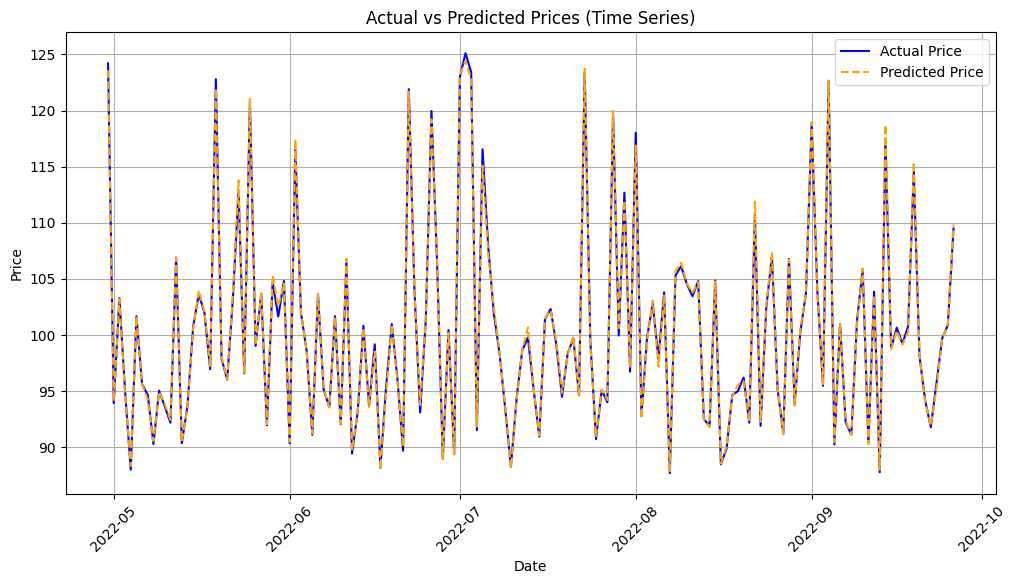

In [15]:
# Ensure y_test and y_pred_final are NumPy arrays
y_test = np.array(y_test)
y_pred_final = np.array(y_pred_final)

# Ensure the date column is correctly formatted
results = pd.DataFrame({
    "date": pd.to_datetime(data["date"].iloc[-len(y_test):].values),
    "actual": y_test,
    "predicted": y_pred_final
})

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(results["date"], results["actual"], label="Actual Price", color="blue")
plt.plot(results["date"], results["predicted"], label="Predicted Price", color="orange", linestyle="--")

plt.title("Actual vs Predicted Prices (Time Series)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()


## Conclusion

In this notebook, we explored a structured approach to financial time series modeling, covering data simulation, preprocessing, predictive modeling, and optimization. We:

- **Generated synthetic financial time series data** to simulate real-world trends.
- **Preprocessed the data using PySpark**, ensuring scalability and efficiency in handling large datasets.
- **Built a robust data pipeline with Scikit-Learn**, streamlining feature engineering and model development.
- **Fine-tuned an XGBoost model using Hyperopt**, leveraging automated hyperparameter optimization to enhance predictive performance.
- **Visualized our predictions using a time series plot**, enabling us to compare model performance against actual values.

This workflow provides a solid foundation for financial data analysis, equipping us with the tools and techniques necessary for developing scalable and effective forecasting models. Future improvements could involve integrating real market data, experimenting with deep learning models, or applying reinforcement learning for trading strategies.